In [97]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as keras
import pandas as pd
import random
import ntpath

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle

In [98]:
datadir = 'Data Collected'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\center_2025_02_13_07_12_11_974.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\left_2025_02_13_07_12_11_974.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\right_2025_02_13_07_12_11_974.jpg,0.0,0.0,0,0.000078
1,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\center_2025_02_13_07_12_12_075.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\left_2025_02_13_07_12_12_075.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\right_2025_02_13_07_12_12_075.jpg,0.0,0.0,0,0.000079
2,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\center_2025_02_13_07_12_12_178.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\left_2025_02_13_07_12_12_178.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\right_2025_02_13_07_12_12_178.jpg,0.0,0.0,0,0.000078
3,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\center_2025_02_13_07_12_12_278.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\left_2025_02_13_07_12_12_278.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\right_2025_02_13_07_12_12_278.jpg,0.0,0.0,0,0.000078
4,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\center_2025_02_13_07_12_12_380.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\left_2025_02_13_07_12_12_380.jpg,C:\Users\3omd4\Desktop\Autonomous Udemy Course\Behavioural Cloning\Data Collected\IMG\right_2025_02_13_07_12_12_380.jpg,0.0,0.0,0,0.000078


In [99]:
def data_plot(data, x_label, y_label):
    plt.bar(center, hist, width=0.05)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
    return

In [100]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2025_02_13_07_12_11_974.jpg,left_2025_02_13_07_12_11_974.jpg,right_2025_02_13_07_12_11_974.jpg,0.0,0.0,0,0.000078
1,center_2025_02_13_07_12_12_075.jpg,left_2025_02_13_07_12_12_075.jpg,right_2025_02_13_07_12_12_075.jpg,0.0,0.0,0,0.000079
2,center_2025_02_13_07_12_12_178.jpg,left_2025_02_13_07_12_12_178.jpg,right_2025_02_13_07_12_12_178.jpg,0.0,0.0,0,0.000078
3,center_2025_02_13_07_12_12_278.jpg,left_2025_02_13_07_12_12_278.jpg,right_2025_02_13_07_12_12_278.jpg,0.0,0.0,0,0.000078
4,center_2025_02_13_07_12_12_380.jpg,left_2025_02_13_07_12_12_380.jpg,right_2025_02_13_07_12_12_380.jpg,0.0,0.0,0,0.000078


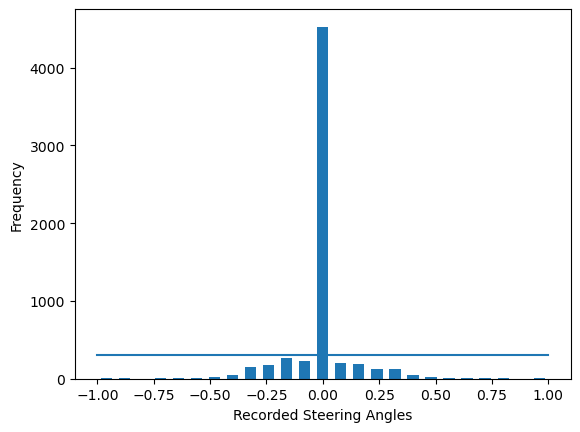

In [101]:
num_bins =25
hist,  bins = np.histogram(data['steering'], num_bins)
center = (bins[: -1] + bins[1:])*-0.5
samples_per_bin = 300

data_plot(data, x_label='Recorded Steering Angles', y_label='Frequency')


total data:  6191
removed:  4226
remaining data:  1965


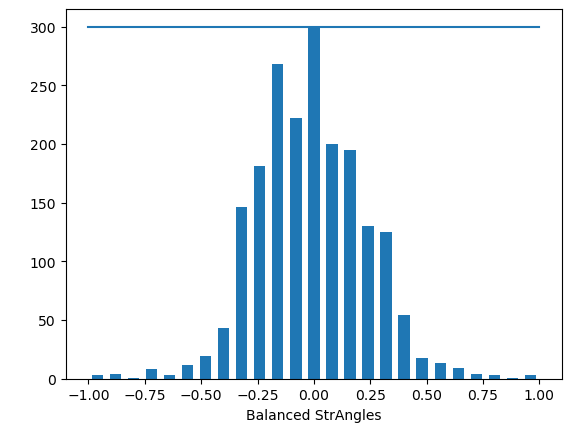

In [102]:
print('total data: ', len(data))
remove_list = []

for bin in range(num_bins):
    lst=[]
    for str_ang in range(len(data['steering'])):
        if data['steering'][str_ang] >= bins[bin] and data['steering'][str_ang] <= bins[bin+1]:
            lst.append(str_ang)
    lst = shuffle(lst)
    lst = lst[samples_per_bin:]
    remove_list.extend(lst)

print('removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data: ', len(data))

hist,  bins = np.histogram(data['steering'], num_bins)
center = (bins[: -1] + bins[1:])*-0.5
samples_per_bin = 300

data_plot(data, x_label='Balanced StrAngles',y_label=' ')


In [103]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        center, left, right = data.iloc[i][0], data.iloc[i][1], data.iloc[i][2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(data.iloc[i][3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings  

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

C:\Users\3omd4\AppData\Local\Temp\ipykernel_23080\734246902.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = data.iloc[i][0], data.iloc[i][1], data.iloc[i][2]
C:\Users\3omd4\AppData\Local\Temp\ipykernel_23080\734246902.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(data.iloc[i][3]))


In [104]:
x_traing, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: {}\nValidation samples: {}'.format(len(x_traing), len(x_valid)))

Training samples: 1572
Validation samples: 393


Text(0.5, 1.0, 'Validation set')

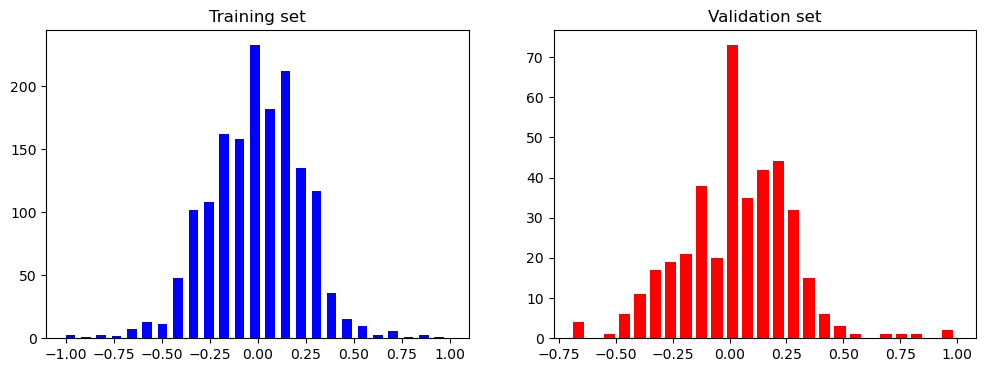

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [106]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[55:130, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))#to match nvidia model input
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

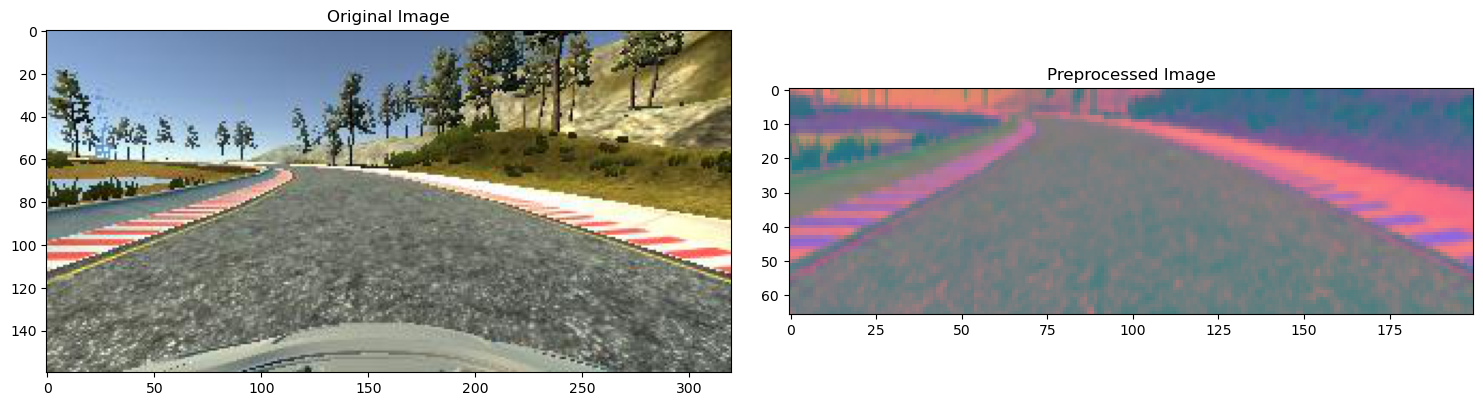

In [107]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)  
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [108]:
x_train = np.array(list(map(img_preprocess, x_traing)))
x_valid = np.array(list(map(img_preprocess, x_valid)))


(1572, 66, 200, 3)


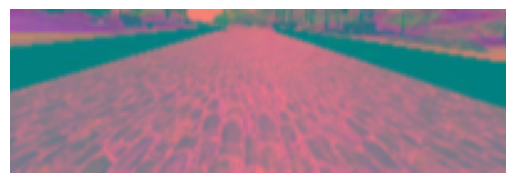

In [120]:
plt.imshow(x_train[random.randint(0, len(x_train)-1)])
plt.axis('off')
print(x_train.shape)

In [ ]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate = 1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model